# A Gentle Introduction to HARK

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/econ-ark/DemArk/master?filepath=%2Fnotebooks%2FGentle-Intro-To-HARK.ipynb)

This notebook provides a simple, hands-on tutorial for first time HARK users -- and potentially first time Python users.  It does not go "into the weeds" - we have hidden some code cells that do boring things that you don't need to digest on your first experience with HARK.  Our aim is to convey a feel for how the toolkit works.

For readers for whom this is your very first experience with Python, we have put important Python concepts in $\textbf{boldface}$. For those for whom this is the first time they have used a Jupyter notebook, we have put Jupyter instructions in $\textit{italics}.$ Only cursory definitions (if any) are provided here.  If you want to learn more, there are many online Python and Jupyter tutorials.

In [1]:
# This cell has a bit of initial setup. You can click the triangle to the left to expand it.
# Click the "Run" button immediately above the notebook in order to execute the contents of any cell
# WARNING: Each cell in the notebook relies upon results generated by previous cells
#   The most common problem beginners have is to execute a cell before all its predecessors
#   If you do this, you can restart the kernel (see the "Kernel" menu above) and start over
%matplotlib inline
import matplotlib.pyplot as plt

# The first step is to be able to bring things in from different directories
import sys 
import os

sys.path.insert(0, os.path.abspath('../lib'))

from util import log_progress

import numpy as np
import HARK 
from time import clock
from copy import deepcopy
mystr = lambda number : "{:.4f}".format(number)
from HARK.utilities import plotFuncs

## Your First HARK Model: Perfect Foresight

$$\newcommand{\CRRA}{\rho}\newcommand{\DiscFac}{\beta}$$
We start with almost the simplest possible consumption model: A consumer with CRRA utility 

\begin{equation}
U(C) = \frac{C^{1-\CRRA}}{1-\rho}
\end{equation}

has perfect foresight about everything except the (stochastic) date of death, which occurs with constant probability implying a "survival probability" $\newcommand{\LivPrb}{\aleph}\LivPrb < 1$.  Permanent labor income $P_t$ grows from period to period by a factor $\Gamma_t$.  At the beginning of each period $t$, the consumer has some amount of market resources $M_t$ (which includes both market wealth and currrent income) and must choose how much of those resources to consume $C_t$ and how much to retain in a riskless asset $A_t$ which will earn return factor $R$. The agent's flow of utility $U(C_t)$ from consumption is geometrically discounted by factor $\beta$. Between periods, the agent dies with probability $\mathsf{D}_t$, ending his problem.

The agent's problem can be written in Bellman form as:

\begin{eqnarray*}
V_t(M_t,P_t) &=& \max_{C_t}~U(C_t) + \beta \aleph V_{t+1}(M_{t+1},P_{t+1}), \\
& s.t. & \\
%A_t &=& M_t - C_t, \\
M_{t+1} &=& R (M_{t}-C_{t}) + Y_{t+1}, \\
P_{t+1} &=& \Gamma_{t+1} P_t, \\
\end{eqnarray*}

A particular perfect foresight agent's problem can be characterized by values of risk aversion $\rho$, discount factor $\beta$, and return factor $R$, along with sequences of income growth factors $\{ \Gamma_t \}$ and survival probabilities $\{\mathsf{\aleph}_t\}$.  To keep things simple, let's forget about "sequences" of income growth and mortality, and just think about an $\textit{infinite horizon}$ consumer with constant income growth and survival probability.

## Representing Agents in HARK

HARK represents agents solving this type of problem as $\textbf{instances}$ of the $\textbf{class}$ $\texttt{PerfForesightConsumerType}$, a $\textbf{subclass}$ of $\texttt{AgentType}$.  To make agents of this class, we must import the class itself into our workspace.  (Run the cell below in order to do this).

In [2]:
from HARK.ConsumptionSaving.ConsIndShockModel import PerfForesightConsumerType

The $\texttt{PerfForesightConsumerType}$ class contains within itself the python code that constructs the solution for the perfect foresight model we are studying here, as specifically articulated in [these lecture notes](http://econ.jhu.edu/people/ccarroll/public/lecturenotes/consumption/PerfForesightCRRA/).  

To create an instance of $\texttt{PerfForesightConsumerType}$, we simply call the class as if it were a function, passing as arguments the specific parameter values we want it to have.  In the hidden cell below, we define a $\textbf{dictionary}$ named $\texttt{PF_dictionary}$ with these parameter values:

| Param | Description | Code | Value |
| :---: | ---  | --- | :---: |
| $\rho$ | Relative risk aversion | $\texttt{CRRA}$ | 2.5 |
| $\beta$ | Discount factor | $\texttt{DiscFac}$ | 0.96 |
| $R$ | Risk free interest factor | $\texttt{Rfree}$ | 1.03 |
| $\newcommand{\LivFac}{\aleph}\LivFac$ | Survival probability | $\texttt{LivPrb}$ | 0.98 |
| $\Gamma$ | Income growth factor | $\texttt{PermGroFac}$ | 1.01 |


For now, don't worry about the specifics of dictionaries.  All you need to know is that a dictionary lets us pass many arguments wrapped up in one simple data structure.

In [3]:
# This cell defines a parameter dictionary. You can expand it if you want to see what that looks like.
PF_dictionary = {
    'CRRA' : 2.5,
    'DiscFac' : 0.96,
    'Rfree' : 1.03,
    'LivPrb' : [0.98],
    'PermGroFac' : [1.01],
    'T_cycle' : 1,
    'cycles' : 0,
    'AgentCount' : 10000
}

# To those curious enough to open this hidden cell, you might notice that we defined
# a few extra parameters in that dictionary: T_cycle, cycles, and AgentCount. Don't
# worry about these for now.

Let's make an $\textbf{object}$ named $\texttt{PFexample}$ which is an $\textbf{instance}$ of the $\texttt{PerfForesightConsumerType}$ class. The object $\texttt{PFexample}$ will bundle together the abstract mathematical description of the solution embodied in $\texttt{PerfForesightConsumerType}$, and the specific set of parameter values defined in $\texttt{PF_dictionary}$.  Such a bundle is created passing $\texttt{PF_dictionary}$ to the class $\texttt{PerfForesightConsumerType}$:

In [4]:
PFexample = PerfForesightConsumerType(**PF_dictionary) 
# the asterisks ** basically say "here come some arguments" to PerfForesightConsumerType

In $\texttt{PFexample}$, we now have _defined_ the problem of a particular infinite horizon perfect foresight consumer who knows how to solve this problem.  

## Solving an Agent's Problem

To tell the agent actually to solve the problem, we call the agent's $\texttt{solve}$ $\textbf{method}$. (A $\textbf{method}$ is essentially a function that an object runs that affects the object's own internal characteristics -- in this case, the method adds the consumption function to the contents of $\texttt{PFexample}$.)

The cell below calls the $\texttt{solve}$ method for $\texttt{PFexample}$

In [5]:
PFexample.solve()

Running the $\texttt{solve}$ method creates the $\textbf{attribute}$ of $\texttt{PFexample}$ named $\texttt{solution}$.  In fact, every subclass of $\texttt{AgentType}$ works the same way: The class definition contains the abstract algorithm that knows how to solve the model, but to obtain the particular solution for a specific instance (paramterization/configuration), that instance must be instructed to $\texttt{solve()}$ its problem.  

The $\texttt{solution}$ attribute is always a $\textit{list}$ of solutions to a single period of the problem. In the case of an infinite horizon model like the one here, there is just one element in that list -- the solution to all periods of the infinite horizon problem.  The consumption function stored as the first element (element 0) of the solution list can be retrieved by:

In [6]:
PFexample.solution[0].cFunc

One of the results proven in the associated [the lecture notes](http://econ.jhu.edu/people/ccarroll/public/lecturenotes/consumption/PerfForesightCRRA/) is that, for the specific problem defined above, there is a solution in which the _ratio_ $c = C/P$ is a linear function of the _ratio_ of market resources to permanent income, $m = M/P$.  

This is why $\texttt{cFunc}$ can be represented by a linear interpolation.  It can be plotted between an $m$ ratio of 0 and 10 using the command below.

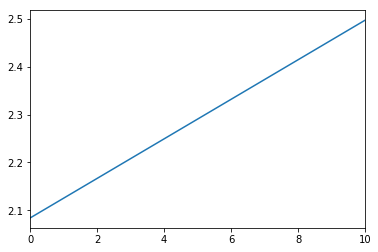

In [7]:
mPlotTop=10
plotFuncs(PFexample.solution[0].cFunc,0.,mPlotTop)

The figure illustrates one of the surprising features of the perfect foresight model: A person with zero money should be spending at a rate more than double their income (that is, $\texttt{cFunc}(0.) \approx 2.08$ - the intersection on the vertical axis).  How can this be?

The answer is that we have not incorporated any constraint that would prevent the agent from borrowing against the entire PDV of future earnings-- human wealth.  How much is that?  What's the minimum value of $m_t$ where the consumption function is defined?  We can check by retrieving the $\texttt{hNrm}$ **attribute** of the solution, which calculates the value of human wealth normalized by permanent income:

In [8]:
humanWealth = PFexample.solution[0].hNrm
mMinimum = PFexample.solution[0].mNrmMin
print("This agent's human wealth is " + str(humanWealth) + ' times his current income level.')
print("This agent's consumption function is defined (consumption is positive) down to m_t = " + str(mMinimum))

This agent's human wealth is 50.49994992551661 times his current income level.
This agent's consumption function is defined (consumption is positive) down to m_t = -50.49994992551661


Yikes! Let's take a look at the bottom of the consumption function.  In the cell below, set the bounds of the $\texttt{plotFuncs}$ function to display down to the lowest defined value of the consumption function.

In [9]:
# YOUR FIRST HANDS-ON EXERCISE!
# Fill in the value for "mPlotBottom" to plot the consumption function from the point where it is zero.
plotFuncs(PFexample.solution[0].cFunc,mPlotBottom,mPlotTop)

NameError: name 'mPlotBottom' is not defined

## Changing Agent Parameters

Suppose you wanted to change one (or more) of the parameters of the agent's problem and see what that does.  We want to compare consumption functions before and after we change parameters, so let's make a new instance of $\texttt{PerfForesightConsumerType}$ by copying $\texttt{PFexample}$.

In [10]:
NewExample = deepcopy(PFexample)

In Python, you can set an $\textbf{attribute}$ of an object just like any other variable.  For example, we could make the new agent less patient:

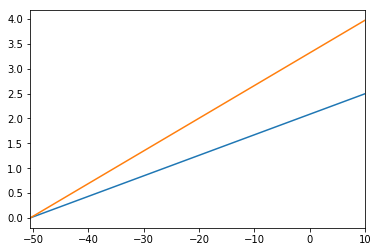

In [11]:
NewExample.DiscFac = 0.90
NewExample.solve()
mPlotBottom = mMinimum
plotFuncs([PFexample.solution[0].cFunc,NewExample.solution[0].cFunc],mPlotBottom,mPlotTop)

(Note that you can pass a **list** of functions to $\texttt{plotFuncs}$ as the first argument rather than just a single function. Lists are written inside of [square brackets].)

Let's try to deal with the "problem" of massive human wealth by making another consumer who has essentially no future income.  We can virtually eliminate human wealth by making the permanent income growth factor $\textit{very}$ small.

In $\texttt{PFexample}$, the agent's income grew by 1 percent per period -- his $\texttt{PermGroFac}$ took the value 1.01. What if our new agent had a growth factor of 0.01 -- his income $\textit{shrinks}$ by 99 percent each period?  In the cell below, set $\texttt{NewExample}$'s discount factor back to its original value, then set its $\texttt{PermGroFac}$ attribute so that the growth factor is 0.01 each period.

Important: Recall that the model at the top of this document said that an agent's problem is characterized by a sequence of income growth factors, but we tabled that concept.  Because $\texttt{PerfForesightConsumerType}$ treats $\texttt{PermGroFac}$ as a $\textit{time-varying}$ attribute, it must be specified as a $\textbf{list}$ (with a single element in this case).

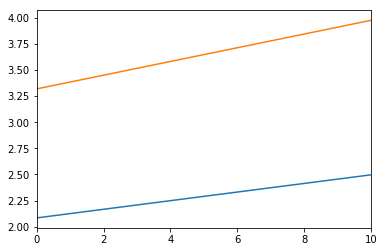

In [12]:
# Revert NewExample's discount factor and make his future income minuscule
# print("your lines here")

# Compare the old and new consumption functions
plotFuncs([PFexample.solution[0].cFunc,NewExample.solution[0].cFunc],0.,10.)

Now $\texttt{NewExample}$'s consumption function has the same slope (MPC) as $\texttt{PFexample}$, but it emanates from (almost) zero-- he has basically no future income to borrow against!

If you'd like, use the cell above to alter $\texttt{NewExample}$'s other attributes (relative risk aversion, etc) and see how the consumption function changes.  However, keep in mind that \textit{no solution exists} for some combinations of parameters.  HARK should let you know if this is the case if you try to solve such a model.


## Your Second HARK Model: Adding Income Shocks

Linear consumption functions are pretty boring, and you'd be justified in feeling unimpressed if all HARK could do was plot some lines.  Let's look at another model that adds two important layers of complexity: income shocks and (artificial) borrowing constraints.

Specifically, our new type of consumer receives two income shocks at the beginning of each period: a completely transitory shock $\theta_t$ and a completely permanent shock $\psi_t$.  Moreover, lenders will not let the agent borrow money such that his ratio of end-of-period assets $A_t$ to permanent income $P_t$ is less than $\underline{a}$.  As with the perfect foresight problem, this model can be framed in terms of $\textit{normalized}$ variables, e.g. $m_t \equiv M_t/P_t$.  (See [here](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/) for all the theory).

\begin{eqnarray*}
v_t(m_t) &=& \max_{c_t} ~ U(c_t) ~ +  \phantom{\LivFac} \beta \mathbb{E} [(\Gamma_{t+1}\psi_{t+1})^{1-\rho} v_{t+1}(m_{t+1}) ], \\
a_t &=& m_t - c_t, \\
a_t &\geq& \underline{a}, \\
m_{t+1} &=& R/(\Gamma_{t+1} \psi_{t+1}) a_t + \theta_{t+1}, \\
\mathbb{E}[\psi]=\mathbb{E}[\theta] &=& 1, \\
u(c) &=& \frac{c^{1-\rho}}{1-\rho}.
\end{eqnarray*}

HARK represents agents with this kind of problem as instances of the class $\texttt{IndShockConsumerType}$.  To create an $\texttt{IndShockConsumerType}$, we must specify the same set of parameters as for a $\texttt{PerfForesightConsumerType}$, as well as an artificial borrowing constraint $\underline{a}$ and a sequence of income shock joint. It's easy enough to pick a borrowing constraint -- say, zero -- but how would we specify the distributions of the shocks?  Can't the joint distribution of permanent and transitory shocks be just about anything?

$\textit{Yes}$, and HARK can handle whatever correlation structure a user might care to specify.  However, the default behavior of $\texttt{IndShockConsumerType}$ is that the distribution of permanent income shocks is mean one lognormal, and the distribution of transitory shocks is mean one lognormal augmented with a point mass representing unemployment.  The distributions are independent of each other by default, and are approximated with $N$ point equiprobable distributions.

Let's make an infinite horizon instance of $\texttt{IndShockConsumerType}$ with the same parameters as our original perfect foresight agent, plus the extra parameters to specify the income shock distribution and the artificial borrowing constraint. As before, we'll make a dictionary:


| Param | Description | Code | Value |
| :---: | --- | --- |  :---: |
| $\underline{a}$ | Artificial borrowing constraint | $\texttt{BoroCnstArt}$ | 0.0 |
| $\sigma_\psi$ | Underlying stdev of permanent income shocks | $\texttt{PermShkStd}$ | 0.1 |
| $\sigma_\theta$ | Underlying stdev of transitory income shocks | $\texttt{TranShkStd}$ | 0.1 |
| $N_\psi$ | Number of discrete permanent income shocks | $\texttt{PermShkCount}$ | 7 |
| $N_\theta$ | Number of discrete transitory income shocks | $\texttt{TranShkCount}$ | 7 |
| $\mho$ | Unemployment probability | $\texttt{UnempPrb}$ | 0.05 |
| $\underline{\theta}$ | Transitory shock when unemployed | $\texttt{IncUnemp}$ | 0.3 |

In [13]:
# This cell defines a parameter dictionary for making an instance of IndShockConsumerType.

IndShockDictionary = {
    'CRRA': 2.5,          # The dictionary includes our original parameters...
    'Rfree': 1.03,
    'DiscFac': 0.96,
    'LivPrb': [0.98],
    'PermGroFac': [1.01],
    'PermShkStd': [0.1],  # ... and the new parameters for constructing the income process.    
    'PermShkCount': 7,
    'TranShkStd': [0.1],
    'TranShkCount': 7,
    'UnempPrb': 0.05,
    'IncUnemp': 0.3,
    'BoroCnstArt': 0.0,
    'aXtraMin': 0.001,    # aXtra parameters specify how to construct the grid of assets.
    'aXtraMax': 50.,      # Don't worry about these for now
    'aXtraNestFac': 3,
    'aXtraCount': 48,
    'aXtraExtra': [None],
    'vFuncBool': False,   # These booleans indicate whether the value function should be calculated
    'CubicBool': False,   # and whether to use cubic spline interpolation. You can ignore them.
    'aNrmInitMean' : -10.,
    'aNrmInitStd' : 0.0,  # These parameters specify the (log) distribution of normalized assets
    'pLvlInitMean' : 0.0, # and permanent income for agents at "birth". They are only relevant in
    'pLvlInitStd' : 0.0,  # simulation and you don't need to worry about them.
    'PermGroFacAgg' : 1.0,
    'T_retire': 0,        # What's this about retirement? ConsIndShock is set up to be able to
    'UnempPrbRet': 0.0,   # handle lifecycle models as well as infinite horizon problems. Swapping
    'IncUnempRet': 0.0,   # out the structure of the income process is easy, but ignore for now.
    'T_age' : None,
    'T_cycle' : 1,
    'cycles' : 0,
    'AgentCount': 10000,
    'tax_rate':0.0,
}
        
# Hey, there's a lot of parameters we didn't tell you about!  Yes, but you don't need to
# think about them for now.

As before, we need to import the relevant subclass of $\texttt{AgentType}$ into our workspace, then create an instance by passing the dictionary to the class as if the class were a function.

In [14]:
from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType
IndShockExample = IndShockConsumerType(**IndShockDictionary)

Now we can solve our new agent's problem just like before, using the $\texttt{solve}$ method.

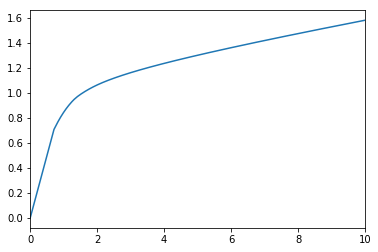

In [15]:
IndShockExample.solve()
plotFuncs(IndShockExample.solution[0].cFunc,0.,10.)

## Changing Constructed Attributes

In the parameter dictionary above, we chose values for HARK to use when constructing its numeric representation of $F_t$, the joint distribution of permanent and transitory income shocks. When $\texttt{IndShockExample}$ was created, those parameters ($\texttt{TranShkStd}$, etc) were used by the $\textbf{constructor}$ or $\textbf{initialization}$ method of $\texttt{IndShockConsumerType}$ to construct an attribute called $\texttt{IncomeDstn}$.

Suppose you were interested in changing (say) the amount of permanent income risk.  From the section above, you might think that you could simply change the attribute $\texttt{TranShkStd}$, solve the model again, and it would work.

That's $\textit{almost}$ true-- there's one extra step. $\texttt{TranShkStd}$ is a primitive input, but it's not the thing you $\textit{actually}$ want to change. Changing $\texttt{TranShkStd}$ doesn't actually update the income distribution... unless you tell it to (just like changing an agent's preferences does not change the consumption function that was stored for the old set of parameters -- until you invoke the $\texttt{solve}$ method again).  In the cell below, we invoke the method $\texttt{updateIncomeProcess}$ so HARK knows to reconstruct the attribute $\texttt{IncomeDstn}$.

In [16]:
OtherExample = deepcopy(IndShockExample)  # Make a copy so we can compare consumption functions
OtherExample.PermShkStd = [0.2]           # Double permanent income risk (note that it's a one element list)
OtherExample.updateIncomeProcess()        # Call the method to reconstruct the representation of F_t
OtherExample.solve()

In the cell below, use your blossoming HARK skills to plot the consumption function for $\texttt{IndShockExample}$ and $\texttt{OtherExample}$ on the same figure.

In [ ]:
# Use the line(s) below to plot the consumptions functions against each other
